In [105]:
# # QC tensorflow installation
# import tensorflow as tf
# import keras
# print(tf.__version__)
# print(keras.__version__)

# Command Space
# %

## Import Libraries

In [106]:
# Import required libraries
import numpy as np
import tensorflow as tf
# from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import os

## Load CIFAR-10 Dataset

We load the CIFAR-10 dataset, perform some preprocessing like normalization and one hot encoding of labels/targets.

In [107]:
import numpy as np
import os

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10_train_test(data_dir):
    """
    Function to load CIFAR-10 training and test data.

    Args:
    data_dir (str): Path to the directory containing CIFAR-10 data files.

    Returns:
    X_train (ndarray): Training data features
    Y_train (ndarray): Training data labels
    X_test (ndarray): Test data features
    Y_test (ndarray): Test data labels
    """
    X_train = []
    Y_train = []

    for i in range(1, 6):  # Load training data from 5 batches
        batch_file = os.path.join(data_dir, 'data_batch_' + str(i))
        batch_data = unpickle(batch_file)
        X_train.append(batch_data[b'data'])
        Y_train += batch_data[b'labels']

    X_train = np.concatenate(X_train, axis=0)
    Y_train = np.array(Y_train)

    # Load test data from the test batch
    test_batch_file = os.path.join(data_dir, 'test_batch')
    test_batch_data = unpickle(test_batch_file)

    X_test = test_batch_data[b'data']
    Y_test = np.array(test_batch_data[b'labels'])

    # Reshaping and re-arranging color channels to represent RGB image required as input to CNN
    # Reshape to (50000, 3, 32, 32) and move the color channel axis to the last dimension
    X_train = X_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    X_test = X_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    return X_train, Y_train, X_test, Y_test


Create validation data from train set (20% split):

In [108]:
from sklearn.model_selection import train_test_split

# Directory containing CIFAR-10 data files
data_dir = 'dataset\cifar-10-python\cifar-10-batches-py'

# Load CIFAR-10 training and test data
X_train, Y_train, X_test, Y_test = load_cifar10_train_test(data_dir)

# Split the training data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [109]:
# Ensuring we parsed the data correctly:
print('Train Set:')
print('X_train shape: ', X_train.shape)
print('Y_train shape: ', Y_train.shape)
print('Validation Set:')
print('X_val shape: ', X_val.shape)
print('Y_val shape: ', Y_val.shape)
print('Test Set:')
print('X_test shape: ', X_test.shape)
print('Y_test shape: ', Y_test.shape)

Train Set:
X_train shape:  (40000, 32, 32, 3)
Y_train shape:  (40000,)
Validation Set:
X_val shape:  (10000, 32, 32, 3)
Y_val shape:  (10000,)
Test Set:
X_test shape:  (10000, 32, 32, 3)
Y_test shape:  (10000,)


### Setup ImageDataGenerator

In order to make the most of fewer training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

NOTE: ImageDataGenerator will NOT add new images to your data set in a sense that it will not make your epochs bigger. Instead, in each epoch it will provide slightly altered images (depending on your configuration). It will always generate new images, no matter how many epochs you have.

So in each epoch model will train on different images, but not too different. This should prevent overfitting and in some way simulates online learning.

In [110]:
from keras.preprocessing.image import ImageDataGenerator

# Construct the training image generator for data augmentation
# datagen = ImageDataGenerator(
#         rotation_range=10, # rotation
#         width_shift_range=0.2, # horizontal shift
#         height_shift_range=0.2, # vertical shift
#         zoom_range=0.2, # zoom
#         horizontal_flip=True, # horizontal flip
#         # brightness_range=[0.2,1.0] # brightness
# )

# For purposes of creating a baseline, construct empty ImageDataGenerator
datagen = ImageDataGenerator()

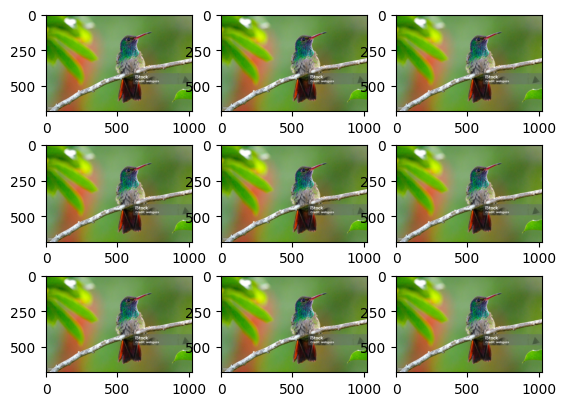

In [111]:
# Example of image augmentation on sample image:
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from matplotlib import pyplot


img = load_img('bird.jpeg') # load image
data = img_to_array(img) # convert to numpy array
samples = expand_dims(data, 0) # expand dimension to one sample

# Prepare iterator
it = datagen.flow(samples, batch_size=1)

# Generate samples and plot
for i in range(9):
    pyplot.subplot(330 + 1 + i) # define subplot
    batch = it.next() # generate batch of images
    image = batch[0].astype('uint8') # convert to unsigned integers
    pyplot.imshow(image)

# show the figure
pyplot.show()
# Adapted code for displaying augmentation results: https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

### Pre-processing dataset

In [112]:
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

# One-hot encode the labels
Y_train = to_categorical(Y_train, 10)
Y_test = to_categorical(Y_test, 10)
Y_val = to_categorical(Y_val, 10)

## Build and Train Model

The following cell has the supporting utility functions to plot accuracy curves, loss curves from training process and final evaluation of the classification model. I have provided inline comments explaining purpose of each function and code used. 

In [113]:
# Import required libraries
import matplotlib.pyplot as plt

def plot_accuracy(history, title):
    """
    Function to plot accuracy curves for both training and validation sets.

    Args:
    history (History): Keras History object containing training history
    title (str): Title of the plot
    """
    new_title = title + " Accuracy"
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(new_title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    save_plot(plt, new_title)
    plt.show()
    
def plot_multiple_accuracies(models, title):
    """
    Function to plot accuracy curves for both training and validation sets of multiple models at once.

    Args:
    models (Dictionary): Contains Keras History objects with training history assigned by keys that pertain to the hyperparameter value used
    title (str): Title of the plot
    """
    new_title = title + " Accuracy"
    for key in models.keys():
        history = models[key]
        plt.plot(history.history['accuracy'], label='train_accuracy' + "_" + key)
        plt.plot(history.history['val_accuracy'], label='val_accuracy' + "_" + key)
    plt.title(new_title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    save_plot(plt, new_title)
    plt.show()

def plot_loss(history, title):
    """
    Function to plot loss curves for both training and validation sets.

    Args:
    history (History): Keras History object containing training history
    title (str): Title of the plot
    """
    new_title = title + " Loss"
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(new_title = title + " Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    save_plot(plt, new_title = title + " Loss")
    plt.show()
    
def plot_multiple_losses(models, title):
    """
    Function to plot loss curves for both training and validation sets.

    Args:
    models (Dictionary): Contains Keras History objects with training history assigned by keys that pertain to the hyperparameter value used
    title (str): Title of the plot
    """
    new_title = title + " Loss"
    for key in models.keys():
        history = models[key]
        plt.plot(history.history['loss'], label='train_loss' + "_" + key)
        plt.plot(history.history['val_loss'], label='val_loss' + "_" + key)
    plt.title(new_title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    save_plot(plt, new_title)
    plt.show()

def evaluate_model(model, X_test, Y_test):
    """
    Function to evaluate the performance of a trained model on the test dataset.

    Args:
    model (Sequential): Trained Keras model
    X_test (ndarray): Test dataset features
    Y_test (ndarray): One-hot encoded labels for test dataset
    """
    _, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print("Test Accuracy: %.2f%%" % (accuracy * 100))
    return accuracy * 100
    
def save_plot(plt, name):
    """
    Function to save a plot. Call function before plt.show().

    Args:
    plt (matplotlib.pyplot object): Plot to save
    name (String): A String for the name of the output file. Cannot contain spaces
    """
    filepath = "Graphs/" + name
    # if os.path.isfile(filepath):
    #     filepath += "_second"
    #     print("Same filename. Please alter the params_string. You will not get another warning before losing figures!!")
    plt.savefig(filepath)


In [114]:
from tensorflow.keras.layers import Input, Add, Activation, AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

def resnet_block(inputs, filters, kernel_size, strides, skip_kernel_size=(1, 1), activation='relu', num_layers=2):
    """
    Function to create a single ResNet block.

    Args:
    inputs (tensor): Input tensor
    filters (int): Number of filters in the convolutional layers
    kernel_size (int or tuple): Size of the convolutional kernel
    strides (int or tuple): Strides of the convolutional kernel
    skip_kernel_size (int or tuple): Size of the skip connection kernel
    activation (str): Activation function to use
    num_layers (int): Number of convolutional layers per block

    Returns:
    tensor: Output tensor of the ResNet block
    """
    shortcut = inputs

    # Create initial convolutional layer and batch normalization without an activation layer afterwards
    x = Conv2D(filters, kernel_size, strides=strides, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    
    # Create (num_layers - 1) convolutional layers with activation layer beforehand
    # Final layer does not have an activation layer as desired
    if num_layers > 1:
        for i in range(num_layers - 1):
            x = Activation(activation)(x)
            x = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
    

    # Shortcut connection
    if strides != 1 or inputs.shape[-1] != filters:
        # change (1,1) to variable (the kernel size in the ith skip connection)
        shortcut = Conv2D(filters, skip_kernel_size, strides=strides, padding='same', kernel_initializer='he_normal')(inputs)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation(activation)(x)
    return x

def build_resnet(init_filters=64, res_layers=[2, 2], conv_kernel_size=(3,3), skip_kernel_size=(1, 1), conv_per_layer=2, pool_size=(8, 8), optimizer='adam'):
    """
    Function to build a ResNet model using multiple Resnet style blocks.
    
    Args:
    init_filters (int): Number of filters in the first layer
    res_layers (list of ints): Network architecture as a list where the length of the list is the number of Residual Layers and the value of each element is the number of blocks in that layer
    conv_kernel_size (int or tuple): Size of the convolutional kernel
    skip_kernel_size (int or tuple): Size of the skip connection kernel
    conv_per_layer (int): Number of convolutional layers per residual block
    pool_size (int or tuple): Size of the pooling layer
    optimizer (String): Acceptable keras optimizers such as SGD or adam

    Returns:
    model (Model): Compiled ResNet model
    """
    inputs = Input(shape=(32, 32, 3))
    num_filters = init_filters
    num_blocks_list = res_layers  # ResNet Style architecture for CIFAR-10

    x = Conv2D(num_filters, conv_kernel_size, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Add ResNet blocks
    for i, num_blocks in enumerate(num_blocks_list):
        for j in range(num_blocks):
            strides = 1
            if i > 0 and j == 0:  # Downsample at the beginning of each stage
                strides = 2
            x = resnet_block(x, num_filters, conv_kernel_size, strides, skip_kernel_size=skip_kernel_size, num_layers=conv_per_layer)

        num_filters *= 2  # Double the number of filters after each stage

    x = AveragePooling2D(pool_size=pool_size)(x) # pool size could be hyperparameter
    x = Flatten()(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    # optimizer can be a parameter: vanilla sgd, sgd with fixed learning rate, or adam 
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [115]:
# Build ResNet Model 1
resnet_model_1 = build_resnet(init_filters=64, res_layers=[1, 1], conv_kernel_size=(3,3), skip_kernel_size=(1, 1), conv_per_layer=2, pool_size=(2, 2), optimizer='SGD')
resnet_model_1.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_249 (Conv2D)            (None, 32, 32, 64)   1792        ['input_22[0][0]']               
                                                                                                  
 batch_normalization_249 (Batch  (None, 32, 32, 64)  256         ['conv2d_249[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_225 (Activation)    (None, 32, 32, 64)   0           ['batch_normalization_249[

In [116]:
# Build ResNet Model 2
resnet_model_2 = build_resnet(init_filters=64, res_layers=[2, 2], conv_kernel_size=(3,3), skip_kernel_size=(1, 1), conv_per_layer=2, pool_size=(2, 2), optimizer='SGD')
resnet_model_2.summary()

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_255 (Conv2D)            (None, 32, 32, 64)   1792        ['input_23[0][0]']               
                                                                                                  
 batch_normalization_255 (Batch  (None, 32, 32, 64)  256         ['conv2d_255[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_230 (Activation)    (None, 32, 32, 64)   0           ['batch_normalization_255[

In [117]:
# Build ResNet Model 3
resnet_model_3 = build_resnet(init_filters=64, res_layers=[3, 3], conv_kernel_size=(3,3), skip_kernel_size=(1, 1), conv_per_layer=2, pool_size=(2, 2), optimizer='SGD')
resnet_model_3.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_265 (Conv2D)            (None, 32, 32, 64)   1792        ['input_24[0][0]']               
                                                                                                  
 batch_normalization_265 (Batch  (None, 32, 32, 64)  256         ['conv2d_265[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_239 (Activation)    (None, 32, 32, 64)   0           ['batch_normalization_265[

In [118]:
# Build ResNet Model 4
resnet_model_4 = build_resnet(init_filters=64, res_layers=[4, 4], conv_kernel_size=(3,3), skip_kernel_size=(1, 1), conv_per_layer=2, pool_size=(2, 2), optimizer='SGD')
resnet_model_4.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_279 (Conv2D)            (None, 32, 32, 64)   1792        ['input_25[0][0]']               
                                                                                                  
 batch_normalization_279 (Batch  (None, 32, 32, 64)  256         ['conv2d_279[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_252 (Activation)    (None, 32, 32, 64)   0           ['batch_normalization_279[

TO DO:
1. keras callbacks: save checkpoint with best performance on validation data (rishie)
2. Add hyperparameter tuning as arguments (gio)
3. Save graphs under different names (gio)
4. ImageDataGenerator - read about this to add augmentation (rishie)
5. Regularization - Dropouts in random/hyperparameter
6. Loading custom data (rishie)

### Enabling Keras Callbacks

Callback to save the Keras model weights after every epoch that obtains the best validation accuracy thus far.

In [119]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Title of the Hypothesis Tested
title = "Varying Blocks Per Residual Layers"

# These are used to distinguish the models from each other
param_1 = "One Block Per Layer"
param_2 = "Two Blocks Per Layer"
param_3 = "Three Blocks Per Layer"
param_4 = "Four Blocks Per Layer"

checkpoint_filepath_1 = 'ckpt/' + title + '/' + param_1
checkpoint_filepath_2 = 'ckpt/' + title + '/' + param_2 
checkpoint_filepath_3 = 'ckpt/' + title + '/' + param_3
checkpoint_filepath_4 = 'ckpt/' + title + '/' + param_4

# Defining callback
model_checkpoint_callback_1 = ModelCheckpoint(
    filepath=checkpoint_filepath_1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model_checkpoint_callback_2 = ModelCheckpoint(
    filepath=checkpoint_filepath_2,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model_checkpoint_callback_3 = ModelCheckpoint(
    filepath=checkpoint_filepath_3,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model_checkpoint_callback_4 = ModelCheckpoint(
    filepath=checkpoint_filepath_4,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [120]:
# Augmenting on the fly with datagen.flow()
batch_size=64
epochs=30

# For running multiple networks at the same time, create dictionary to store history values and lists to store all other info
histories = {}
keys = [param_1, param_2, param_3, param_4] #
models = [resnet_model_1, resnet_model_2, resnet_model_3, resnet_model_4] #
checkpoints = [model_checkpoint_callback_1, model_checkpoint_callback_2, model_checkpoint_callback_3, model_checkpoint_callback_4] #
# Explain whats happening here!!!
for i in range(len(models)):
# Directly use .flow() to load our dataset in batches for training
    histories[keys[i]] = models[i].fit(datagen.flow(X_train, Y_train, batch_size=batch_size), 
                                    epochs = epochs, # set number of epochs
                                    steps_per_epoch = X_train.shape[0]//batch_size, # number of images composing one epoch
                                    validation_data = (X_val, Y_val), # data for validation
                                    callbacks=[checkpoints[i]], # model checkpoint
                                    verbose=1)

Epoch 1/30
620/625 [============================>.] - ETA: 0s - loss: 1.6315 - accuracy: 0.4526

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\One Block Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\One Block Per Layer\assets


625/625 [==============================] - 9s 13ms/step - loss: 1.6289 - accuracy: 0.4533 - val_loss: 1.2556 - val_accuracy: 0.5529
Epoch 2/30
624/625 [============================>.] - ETA: 0s - loss: 1.1381 - accuracy: 0.5973

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\One Block Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\One Block Per Layer\assets


625/625 [==============================] - 8s 12ms/step - loss: 1.1380 - accuracy: 0.5974 - val_loss: 1.1204 - val_accuracy: 0.6033
Epoch 3/30
622/625 [============================>.] - ETA: 0s - loss: 0.9735 - accuracy: 0.6585

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\One Block Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\One Block Per Layer\assets


625/625 [==============================] - 7s 12ms/step - loss: 0.9738 - accuracy: 0.6585 - val_loss: 1.0571 - val_accuracy: 0.6296
Epoch 4/30
625/625 [==============================] - 6s 9ms/step - loss: 0.8691 - accuracy: 0.6956 - val_loss: 1.0989 - val_accuracy: 0.6223
Epoch 5/30
625/625 [==============================] - 6s 9ms/step - loss: 0.7929 - accuracy: 0.7246 - val_loss: 1.0999 - val_accuracy: 0.6271
Epoch 6/30
621/625 [============================>.] - ETA: 0s - loss: 0.7280 - accuracy: 0.7471

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\One Block Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\One Block Per Layer\assets


625/625 [==============================] - 7s 12ms/step - loss: 0.7282 - accuracy: 0.7470 - val_loss: 0.9411 - val_accuracy: 0.6750
Epoch 7/30
624/625 [============================>.] - ETA: 0s - loss: 0.6751 - accuracy: 0.7662

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\One Block Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\One Block Per Layer\assets


625/625 [==============================] - 8s 12ms/step - loss: 0.6751 - accuracy: 0.7661 - val_loss: 0.8881 - val_accuracy: 0.6909
Epoch 8/30
625/625 [==============================] - 6s 10ms/step - loss: 0.6216 - accuracy: 0.7856 - val_loss: 1.1463 - val_accuracy: 0.6395
Epoch 9/30
625/625 [==============================] - 6s 9ms/step - loss: 0.5808 - accuracy: 0.8024 - val_loss: 0.9761 - val_accuracy: 0.6834
Epoch 10/30
625/625 [==============================] - 6s 9ms/step - loss: 0.5366 - accuracy: 0.8168 - val_loss: 0.9442 - val_accuracy: 0.6864
Epoch 11/30
625/625 [==============================] - 6s 9ms/step - loss: 0.4995 - accuracy: 0.8288 - val_loss: 1.0295 - val_accuracy: 0.6713
Epoch 12/30
620/625 [============================>.] - ETA: 0s - loss: 0.4633 - accuracy: 0.8446

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\One Block Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\One Block Per Layer\assets


625/625 [==============================] - 7s 11ms/step - loss: 0.4633 - accuracy: 0.8449 - val_loss: 0.9585 - val_accuracy: 0.6948
Epoch 13/30
625/625 [==============================] - 6s 9ms/step - loss: 0.4291 - accuracy: 0.8567 - val_loss: 0.9960 - val_accuracy: 0.6768
Epoch 14/30
625/625 [==============================] - ETA: 0s - loss: 0.3973 - accuracy: 0.8702

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\One Block Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\One Block Per Layer\assets


625/625 [==============================] - 7s 12ms/step - loss: 0.3973 - accuracy: 0.8702 - val_loss: 0.9018 - val_accuracy: 0.7029
Epoch 15/30
620/625 [============================>.] - ETA: 0s - loss: 0.3668 - accuracy: 0.8814

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\One Block Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\One Block Per Layer\assets


625/625 [==============================] - 8s 13ms/step - loss: 0.3663 - accuracy: 0.8817 - val_loss: 0.8740 - val_accuracy: 0.7035
Epoch 16/30
625/625 [==============================] - 6s 10ms/step - loss: 0.3377 - accuracy: 0.8941 - val_loss: 0.9181 - val_accuracy: 0.7030
Epoch 17/30
623/625 [============================>.] - ETA: 0s - loss: 0.3120 - accuracy: 0.9039

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\One Block Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\One Block Per Layer\assets


625/625 [==============================] - 8s 12ms/step - loss: 0.3124 - accuracy: 0.9036 - val_loss: 0.8970 - val_accuracy: 0.7053
Epoch 18/30
625/625 [==============================] - 6s 9ms/step - loss: 0.2840 - accuracy: 0.9143 - val_loss: 1.1073 - val_accuracy: 0.6699
Epoch 19/30
625/625 [==============================] - ETA: 0s - loss: 0.2615 - accuracy: 0.9247

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\One Block Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\One Block Per Layer\assets


625/625 [==============================] - 7s 12ms/step - loss: 0.2615 - accuracy: 0.9247 - val_loss: 0.9017 - val_accuracy: 0.7159
Epoch 20/30
625/625 [==============================] - ETA: 0s - loss: 0.2397 - accuracy: 0.9329

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\One Block Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\One Block Per Layer\assets


625/625 [==============================] - 7s 12ms/step - loss: 0.2397 - accuracy: 0.9329 - val_loss: 0.8582 - val_accuracy: 0.7258
Epoch 21/30
625/625 [==============================] - 6s 9ms/step - loss: 0.2164 - accuracy: 0.9432 - val_loss: 0.8978 - val_accuracy: 0.7189
Epoch 22/30
625/625 [==============================] - 5s 9ms/step - loss: 0.1987 - accuracy: 0.9501 - val_loss: 0.9004 - val_accuracy: 0.7179
Epoch 23/30
625/625 [==============================] - 5s 9ms/step - loss: 0.1834 - accuracy: 0.9544 - val_loss: 0.8973 - val_accuracy: 0.7242
Epoch 24/30
625/625 [==============================] - ETA: 0s - loss: 0.1654 - accuracy: 0.9632

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\One Block Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\One Block Per Layer\assets


625/625 [==============================] - 7s 11ms/step - loss: 0.1654 - accuracy: 0.9632 - val_loss: 0.9125 - val_accuracy: 0.7269
Epoch 25/30
625/625 [==============================] - 6s 9ms/step - loss: 0.1527 - accuracy: 0.9661 - val_loss: 1.0116 - val_accuracy: 0.7047
Epoch 26/30
624/625 [============================>.] - ETA: 0s - loss: 0.1361 - accuracy: 0.9735

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\One Block Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\One Block Per Layer\assets


625/625 [==============================] - 7s 12ms/step - loss: 0.1361 - accuracy: 0.9735 - val_loss: 0.9044 - val_accuracy: 0.7270
Epoch 27/30
621/625 [============================>.] - ETA: 0s - loss: 0.1235 - accuracy: 0.9776

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\One Block Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\One Block Per Layer\assets


625/625 [==============================] - 8s 12ms/step - loss: 0.1235 - accuracy: 0.9776 - val_loss: 0.8956 - val_accuracy: 0.7322
Epoch 28/30
625/625 [==============================] - 6s 10ms/step - loss: 0.1126 - accuracy: 0.9825 - val_loss: 0.9244 - val_accuracy: 0.7227
Epoch 29/30
625/625 [==============================] - 6s 9ms/step - loss: 0.1038 - accuracy: 0.9837 - val_loss: 0.9415 - val_accuracy: 0.7289
Epoch 30/30
625/625 [==============================] - 5s 9ms/step - loss: 0.0913 - accuracy: 0.9884 - val_loss: 0.9519 - val_accuracy: 0.7286
Epoch 1/30
624/625 [============================>.] - ETA: 0s - loss: 2.0928 - accuracy: 0.4069

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Two Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Two Blocks Per Layer\assets


625/625 [==============================] - 12s 18ms/step - loss: 2.0918 - accuracy: 0.4070 - val_loss: 1.3860 - val_accuracy: 0.5086
Epoch 2/30
624/625 [============================>.] - ETA: 0s - loss: 1.2283 - accuracy: 0.5660

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Two Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Two Blocks Per Layer\assets


625/625 [==============================] - 12s 20ms/step - loss: 1.2276 - accuracy: 0.5663 - val_loss: 1.1475 - val_accuracy: 0.5921
Epoch 3/30
624/625 [============================>.] - ETA: 0s - loss: 1.0376 - accuracy: 0.6326

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Two Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Two Blocks Per Layer\assets


625/625 [==============================] - 12s 19ms/step - loss: 1.0375 - accuracy: 0.6327 - val_loss: 1.1462 - val_accuracy: 0.6019
Epoch 4/30
624/625 [============================>.] - ETA: 0s - loss: 0.9048 - accuracy: 0.6811

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Two Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Two Blocks Per Layer\assets


625/625 [==============================] - 12s 20ms/step - loss: 0.9051 - accuracy: 0.6809 - val_loss: 1.0359 - val_accuracy: 0.6492
Epoch 5/30
623/625 [============================>.] - ETA: 0s - loss: 0.7943 - accuracy: 0.7234

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Two Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Two Blocks Per Layer\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.7937 - accuracy: 0.7236 - val_loss: 0.9662 - val_accuracy: 0.6665
Epoch 6/30
625/625 [==============================] - ETA: 0s - loss: 0.7051 - accuracy: 0.7564

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Two Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Two Blocks Per Layer\assets


625/625 [==============================] - 11s 18ms/step - loss: 0.7051 - accuracy: 0.7564 - val_loss: 0.9228 - val_accuracy: 0.6886
Epoch 7/30
625/625 [==============================] - ETA: 0s - loss: 0.6288 - accuracy: 0.7832

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Two Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Two Blocks Per Layer\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.6288 - accuracy: 0.7832 - val_loss: 0.8749 - val_accuracy: 0.7008
Epoch 8/30
625/625 [==============================] - 9s 15ms/step - loss: 0.5616 - accuracy: 0.8055 - val_loss: 1.0360 - val_accuracy: 0.6616
Epoch 9/30
625/625 [==============================] - 9s 14ms/step - loss: 0.4993 - accuracy: 0.8289 - val_loss: 0.9455 - val_accuracy: 0.6869
Epoch 10/30
625/625 [==============================] - ETA: 0s - loss: 0.4484 - accuracy: 0.8472

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Two Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Two Blocks Per Layer\assets


625/625 [==============================] - 11s 18ms/step - loss: 0.4484 - accuracy: 0.8472 - val_loss: 0.8902 - val_accuracy: 0.7042
Epoch 11/30
624/625 [============================>.] - ETA: 0s - loss: 0.3938 - accuracy: 0.8692

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Two Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Two Blocks Per Layer\assets


625/625 [==============================] - 12s 20ms/step - loss: 0.3936 - accuracy: 0.8693 - val_loss: 0.8167 - val_accuracy: 0.7308
Epoch 12/30
625/625 [==============================] - 10s 15ms/step - loss: 0.3464 - accuracy: 0.8860 - val_loss: 0.8572 - val_accuracy: 0.7168
Epoch 13/30
625/625 [==============================] - 9s 14ms/step - loss: 0.3018 - accuracy: 0.9041 - val_loss: 0.9349 - val_accuracy: 0.7045
Epoch 14/30
625/625 [==============================] - 9s 15ms/step - loss: 0.2594 - accuracy: 0.9227 - val_loss: 0.8555 - val_accuracy: 0.7225
Epoch 15/30
625/625 [==============================] - ETA: 0s - loss: 0.2246 - accuracy: 0.9350

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Two Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Two Blocks Per Layer\assets


625/625 [==============================] - 11s 18ms/step - loss: 0.2246 - accuracy: 0.9350 - val_loss: 0.8462 - val_accuracy: 0.7352
Epoch 16/30
625/625 [==============================] - 10s 15ms/step - loss: 0.1915 - accuracy: 0.9483 - val_loss: 0.9010 - val_accuracy: 0.7174
Epoch 17/30
625/625 [==============================] - 9s 14ms/step - loss: 0.1607 - accuracy: 0.9613 - val_loss: 0.8830 - val_accuracy: 0.7247
Epoch 18/30
625/625 [==============================] - ETA: 0s - loss: 0.1363 - accuracy: 0.9699

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Two Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Two Blocks Per Layer\assets


625/625 [==============================] - 12s 19ms/step - loss: 0.1363 - accuracy: 0.9699 - val_loss: 0.8382 - val_accuracy: 0.7438
Epoch 19/30
625/625 [==============================] - 10s 15ms/step - loss: 0.1166 - accuracy: 0.9771 - val_loss: 0.8871 - val_accuracy: 0.7383
Epoch 20/30
625/625 [==============================] - 9s 14ms/step - loss: 0.0976 - accuracy: 0.9840 - val_loss: 0.9194 - val_accuracy: 0.7329
Epoch 21/30
622/625 [============================>.] - ETA: 0s - loss: 0.0835 - accuracy: 0.9883

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Two Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Two Blocks Per Layer\assets


625/625 [==============================] - 11s 18ms/step - loss: 0.0834 - accuracy: 0.9884 - val_loss: 0.8696 - val_accuracy: 0.7472
Epoch 22/30
625/625 [==============================] - 10s 15ms/step - loss: 0.0688 - accuracy: 0.9923 - val_loss: 0.9220 - val_accuracy: 0.7373
Epoch 23/30
625/625 [==============================] - 9s 15ms/step - loss: 0.0574 - accuracy: 0.9954 - val_loss: 0.9333 - val_accuracy: 0.7338
Epoch 24/30
625/625 [==============================] - 9s 14ms/step - loss: 0.0490 - accuracy: 0.9967 - val_loss: 0.9038 - val_accuracy: 0.7446
Epoch 25/30
622/625 [============================>.] - ETA: 0s - loss: 0.0437 - accuracy: 0.9976

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Two Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Two Blocks Per Layer\assets


625/625 [==============================] - 11s 18ms/step - loss: 0.0437 - accuracy: 0.9976 - val_loss: 0.8899 - val_accuracy: 0.7477
Epoch 26/30
624/625 [============================>.] - ETA: 0s - loss: 0.0371 - accuracy: 0.9983

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Two Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Two Blocks Per Layer\assets


625/625 [==============================] - 11s 18ms/step - loss: 0.0371 - accuracy: 0.9983 - val_loss: 0.9165 - val_accuracy: 0.7482
Epoch 27/30
623/625 [============================>.] - ETA: 0s - loss: 0.0326 - accuracy: 0.9990

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Two Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Two Blocks Per Layer\assets


625/625 [==============================] - 11s 18ms/step - loss: 0.0326 - accuracy: 0.9990 - val_loss: 0.9074 - val_accuracy: 0.7526
Epoch 28/30
625/625 [==============================] - 9s 14ms/step - loss: 0.0286 - accuracy: 0.9993 - val_loss: 0.9157 - val_accuracy: 0.7490
Epoch 29/30
625/625 [==============================] - ETA: 0s - loss: 0.0259 - accuracy: 0.9995

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Two Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Two Blocks Per Layer\assets


625/625 [==============================] - 11s 17ms/step - loss: 0.0259 - accuracy: 0.9995 - val_loss: 0.9194 - val_accuracy: 0.7551
Epoch 30/30
622/625 [============================>.] - ETA: 0s - loss: 0.0232 - accuracy: 0.9995

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Two Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Two Blocks Per Layer\assets


625/625 [==============================] - 12s 20ms/step - loss: 0.0233 - accuracy: 0.9995 - val_loss: 0.9293 - val_accuracy: 0.7558
Epoch 1/30
623/625 [============================>.] - ETA: 0s - loss: 2.2659 - accuracy: 0.4030

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Three Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Three Blocks Per Layer\assets


625/625 [==============================] - 18s 27ms/step - loss: 2.2637 - accuracy: 0.4032 - val_loss: 1.4837 - val_accuracy: 0.4767
Epoch 2/30
625/625 [==============================] - ETA: 0s - loss: 1.2698 - accuracy: 0.5473

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Three Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Three Blocks Per Layer\assets


625/625 [==============================] - 17s 26ms/step - loss: 1.2698 - accuracy: 0.5473 - val_loss: 1.2397 - val_accuracy: 0.5556
Epoch 3/30
623/625 [============================>.] - ETA: 0s - loss: 1.0986 - accuracy: 0.6100

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Three Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Three Blocks Per Layer\assets


625/625 [==============================] - 16s 26ms/step - loss: 1.0982 - accuracy: 0.6100 - val_loss: 1.1465 - val_accuracy: 0.5868
Epoch 4/30
625/625 [==============================] - ETA: 0s - loss: 0.9735 - accuracy: 0.6550

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Three Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Three Blocks Per Layer\assets


625/625 [==============================] - 16s 25ms/step - loss: 0.9735 - accuracy: 0.6550 - val_loss: 1.0615 - val_accuracy: 0.6371
Epoch 5/30
625/625 [==============================] - ETA: 0s - loss: 0.8671 - accuracy: 0.6967

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Three Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Three Blocks Per Layer\assets


625/625 [==============================] - 16s 26ms/step - loss: 0.8671 - accuracy: 0.6967 - val_loss: 1.0532 - val_accuracy: 0.6450
Epoch 6/30
624/625 [============================>.] - ETA: 0s - loss: 0.7808 - accuracy: 0.7250

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Three Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Three Blocks Per Layer\assets


625/625 [==============================] - 16s 26ms/step - loss: 0.7805 - accuracy: 0.7252 - val_loss: 0.9204 - val_accuracy: 0.6863
Epoch 7/30
625/625 [==============================] - ETA: 0s - loss: 0.7088 - accuracy: 0.7525

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Three Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Three Blocks Per Layer\assets


625/625 [==============================] - 17s 27ms/step - loss: 0.7088 - accuracy: 0.7525 - val_loss: 0.9143 - val_accuracy: 0.6921
Epoch 8/30
623/625 [============================>.] - ETA: 0s - loss: 0.6361 - accuracy: 0.7745

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Three Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Three Blocks Per Layer\assets


625/625 [==============================] - 16s 26ms/step - loss: 0.6360 - accuracy: 0.7745 - val_loss: 0.9129 - val_accuracy: 0.6989
Epoch 9/30
625/625 [==============================] - 13s 21ms/step - loss: 0.5744 - accuracy: 0.7990 - val_loss: 0.9263 - val_accuracy: 0.6957
Epoch 10/30
624/625 [============================>.] - ETA: 0s - loss: 0.5203 - accuracy: 0.8185

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Three Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Three Blocks Per Layer\assets


625/625 [==============================] - 16s 25ms/step - loss: 0.5203 - accuracy: 0.8186 - val_loss: 0.9755 - val_accuracy: 0.7081
Epoch 11/30
625/625 [==============================] - 12s 20ms/step - loss: 0.4538 - accuracy: 0.8414 - val_loss: 0.9610 - val_accuracy: 0.6960
Epoch 12/30
625/625 [==============================] - 12s 19ms/step - loss: 0.3961 - accuracy: 0.8618 - val_loss: 1.0012 - val_accuracy: 0.6897
Epoch 13/30
625/625 [==============================] - 12s 19ms/step - loss: 0.3359 - accuracy: 0.8843 - val_loss: 1.1718 - val_accuracy: 0.6598
Epoch 14/30
625/625 [==============================] - ETA: 0s - loss: 0.2826 - accuracy: 0.9043

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Three Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Three Blocks Per Layer\assets


625/625 [==============================] - 16s 25ms/step - loss: 0.2826 - accuracy: 0.9043 - val_loss: 0.9183 - val_accuracy: 0.7189
Epoch 15/30
625/625 [==============================] - 13s 21ms/step - loss: 0.2345 - accuracy: 0.9230 - val_loss: 1.1084 - val_accuracy: 0.6880
Epoch 16/30
625/625 [==============================] - 12s 20ms/step - loss: 0.1851 - accuracy: 0.9417 - val_loss: 1.0435 - val_accuracy: 0.7074
Epoch 17/30
625/625 [==============================] - 12s 20ms/step - loss: 0.1358 - accuracy: 0.9613 - val_loss: 1.0777 - val_accuracy: 0.7044
Epoch 18/30
624/625 [============================>.] - ETA: 0s - loss: 0.0996 - accuracy: 0.9745

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Three Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Three Blocks Per Layer\assets


625/625 [==============================] - 16s 26ms/step - loss: 0.0997 - accuracy: 0.9745 - val_loss: 1.0163 - val_accuracy: 0.7241
Epoch 19/30
624/625 [============================>.] - ETA: 0s - loss: 0.0675 - accuracy: 0.9878

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Three Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Three Blocks Per Layer\assets


625/625 [==============================] - 17s 26ms/step - loss: 0.0675 - accuracy: 0.9879 - val_loss: 0.9786 - val_accuracy: 0.7368
Epoch 20/30
623/625 [============================>.] - ETA: 0s - loss: 0.0490 - accuracy: 0.9929

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Three Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Three Blocks Per Layer\assets


625/625 [==============================] - 17s 27ms/step - loss: 0.0490 - accuracy: 0.9929 - val_loss: 1.0008 - val_accuracy: 0.7398
Epoch 21/30
625/625 [==============================] - ETA: 0s - loss: 0.0374 - accuracy: 0.9963

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Three Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Three Blocks Per Layer\assets


625/625 [==============================] - 16s 25ms/step - loss: 0.0374 - accuracy: 0.9963 - val_loss: 0.9943 - val_accuracy: 0.7461
Epoch 22/30
625/625 [==============================] - 13s 20ms/step - loss: 0.0266 - accuracy: 0.9983 - val_loss: 1.0378 - val_accuracy: 0.7414
Epoch 23/30
623/625 [============================>.] - ETA: 0s - loss: 0.0219 - accuracy: 0.9990

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Three Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Three Blocks Per Layer\assets


625/625 [==============================] - 16s 26ms/step - loss: 0.0219 - accuracy: 0.9990 - val_loss: 0.9891 - val_accuracy: 0.7534
Epoch 24/30
625/625 [==============================] - 13s 20ms/step - loss: 0.0169 - accuracy: 0.9995 - val_loss: 1.0514 - val_accuracy: 0.7506
Epoch 25/30
624/625 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.9997

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Three Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Three Blocks Per Layer\assets


625/625 [==============================] - 16s 26ms/step - loss: 0.0149 - accuracy: 0.9998 - val_loss: 0.9901 - val_accuracy: 0.7599
Epoch 26/30
625/625 [==============================] - 13s 21ms/step - loss: 0.0133 - accuracy: 0.9996 - val_loss: 1.0207 - val_accuracy: 0.7591
Epoch 27/30
625/625 [==============================] - 13s 20ms/step - loss: 0.0110 - accuracy: 0.9998 - val_loss: 1.0122 - val_accuracy: 0.7574
Epoch 28/30
625/625 [==============================] - ETA: 0s - loss: 0.0098 - accuracy: 0.9999

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Three Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Three Blocks Per Layer\assets


625/625 [==============================] - 15s 24ms/step - loss: 0.0098 - accuracy: 0.9999 - val_loss: 1.0043 - val_accuracy: 0.7654
Epoch 29/30
625/625 [==============================] - 13s 21ms/step - loss: 0.0088 - accuracy: 0.9999 - val_loss: 1.0250 - val_accuracy: 0.7549
Epoch 30/30
625/625 [==============================] - 12s 20ms/step - loss: 0.0077 - accuracy: 0.9999 - val_loss: 1.0283 - val_accuracy: 0.7630
Epoch 1/30
623/625 [============================>.] - ETA: 0s - loss: 2.3534 - accuracy: 0.3912

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Four Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Four Blocks Per Layer\assets


625/625 [==============================] - 21s 32ms/step - loss: 2.3506 - accuracy: 0.3914 - val_loss: 1.4414 - val_accuracy: 0.4926
Epoch 2/30
624/625 [============================>.] - ETA: 0s - loss: 1.2792 - accuracy: 0.5457

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Four Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Four Blocks Per Layer\assets


625/625 [==============================] - 21s 33ms/step - loss: 1.2792 - accuracy: 0.5458 - val_loss: 1.2235 - val_accuracy: 0.5599
Epoch 3/30
624/625 [============================>.] - ETA: 0s - loss: 1.1018 - accuracy: 0.6068

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Four Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Four Blocks Per Layer\assets


625/625 [==============================] - 21s 33ms/step - loss: 1.1015 - accuracy: 0.6069 - val_loss: 1.1953 - val_accuracy: 0.5776
Epoch 4/30
624/625 [============================>.] - ETA: 0s - loss: 0.9737 - accuracy: 0.6563

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Four Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Four Blocks Per Layer\assets


625/625 [==============================] - 21s 33ms/step - loss: 0.9734 - accuracy: 0.6565 - val_loss: 0.9982 - val_accuracy: 0.6448
Epoch 5/30
625/625 [==============================] - ETA: 0s - loss: 0.8642 - accuracy: 0.6951

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Four Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Four Blocks Per Layer\assets


625/625 [==============================] - 21s 33ms/step - loss: 0.8642 - accuracy: 0.6951 - val_loss: 0.9580 - val_accuracy: 0.6623
Epoch 6/30
625/625 [==============================] - ETA: 0s - loss: 0.7710 - accuracy: 0.7276

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Four Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Four Blocks Per Layer\assets


625/625 [==============================] - 21s 34ms/step - loss: 0.7710 - accuracy: 0.7276 - val_loss: 0.8859 - val_accuracy: 0.6855
Epoch 7/30
623/625 [============================>.] - ETA: 0s - loss: 0.6952 - accuracy: 0.7574

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Four Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Four Blocks Per Layer\assets


625/625 [==============================] - 21s 33ms/step - loss: 0.6953 - accuracy: 0.7574 - val_loss: 0.8675 - val_accuracy: 0.7007
Epoch 8/30
623/625 [============================>.] - ETA: 0s - loss: 0.6293 - accuracy: 0.7830

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Four Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Four Blocks Per Layer\assets


625/625 [==============================] - 21s 33ms/step - loss: 0.6289 - accuracy: 0.7831 - val_loss: 0.8417 - val_accuracy: 0.7147
Epoch 9/30
625/625 [==============================] - 17s 26ms/step - loss: 0.5629 - accuracy: 0.8044 - val_loss: 0.9309 - val_accuracy: 0.6922
Epoch 10/30
625/625 [==============================] - 16s 25ms/step - loss: 0.5070 - accuracy: 0.8218 - val_loss: 0.8591 - val_accuracy: 0.7136
Epoch 11/30
625/625 [==============================] - 16s 25ms/step - loss: 0.4493 - accuracy: 0.8416 - val_loss: 0.9483 - val_accuracy: 0.7065
Epoch 12/30
625/625 [==============================] - ETA: 0s - loss: 0.3949 - accuracy: 0.8630

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Four Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Four Blocks Per Layer\assets


625/625 [==============================] - 20s 32ms/step - loss: 0.3949 - accuracy: 0.8630 - val_loss: 0.8324 - val_accuracy: 0.7410
Epoch 13/30
625/625 [==============================] - 16s 26ms/step - loss: 0.3389 - accuracy: 0.8816 - val_loss: 0.8591 - val_accuracy: 0.7315
Epoch 14/30
625/625 [==============================] - 16s 26ms/step - loss: 0.2824 - accuracy: 0.9033 - val_loss: 1.1728 - val_accuracy: 0.6866
Epoch 15/30
625/625 [==============================] - 17s 27ms/step - loss: 0.2347 - accuracy: 0.9203 - val_loss: 0.9254 - val_accuracy: 0.7283
Epoch 16/30
625/625 [==============================] - 16s 26ms/step - loss: 0.1879 - accuracy: 0.9384 - val_loss: 0.9149 - val_accuracy: 0.7397
Epoch 17/30
625/625 [==============================] - 16s 25ms/step - loss: 0.1436 - accuracy: 0.9556 - val_loss: 1.0337 - val_accuracy: 0.7265
Epoch 18/30
625/625 [==============================] - 16s 25ms/step - loss: 0.1109 - accuracy: 0.9674 - val_loss: 1.0028 - val_accuracy: 0.73

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Four Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Four Blocks Per Layer\assets


625/625 [==============================] - 20s 32ms/step - loss: 0.0576 - accuracy: 0.9879 - val_loss: 1.0705 - val_accuracy: 0.7443
Epoch 21/30
625/625 [==============================] - 17s 27ms/step - loss: 0.0401 - accuracy: 0.9933 - val_loss: 1.0718 - val_accuracy: 0.7367
Epoch 22/30
624/625 [============================>.] - ETA: 0s - loss: 0.0268 - accuracy: 0.9971

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Four Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Four Blocks Per Layer\assets


625/625 [==============================] - 20s 32ms/step - loss: 0.0268 - accuracy: 0.9971 - val_loss: 0.9534 - val_accuracy: 0.7678
Epoch 23/30
625/625 [==============================] - 16s 25ms/step - loss: 0.0220 - accuracy: 0.9979 - val_loss: 1.0531 - val_accuracy: 0.7559
Epoch 24/30
625/625 [==============================] - 16s 25ms/step - loss: 0.0181 - accuracy: 0.9984 - val_loss: 1.0686 - val_accuracy: 0.7561
Epoch 25/30
625/625 [==============================] - ETA: 0s - loss: 0.0129 - accuracy: 0.9992

INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Four Blocks Per Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Blocks Per Residual Layers\Four Blocks Per Layer\assets


625/625 [==============================] - 20s 32ms/step - loss: 0.0129 - accuracy: 0.9992 - val_loss: 0.9791 - val_accuracy: 0.7745
Epoch 26/30
625/625 [==============================] - 16s 25ms/step - loss: 0.0110 - accuracy: 0.9997 - val_loss: 1.0004 - val_accuracy: 0.7699
Epoch 27/30
625/625 [==============================] - 16s 25ms/step - loss: 0.0082 - accuracy: 0.9998 - val_loss: 1.0105 - val_accuracy: 0.7683
Epoch 28/30
625/625 [==============================] - 16s 25ms/step - loss: 0.0073 - accuracy: 0.9999 - val_loss: 0.9974 - val_accuracy: 0.7726
Epoch 29/30
507/625 [=======================>......] - ETA: 2s - loss: 0.0065 - accuracy: 0.9998

In [ ]:
# resnet_history = resnet_model.fit(X_train, Y_train, batch_size=64, epochs=10, verbose=1, validation_data=(X_val, Y_val))


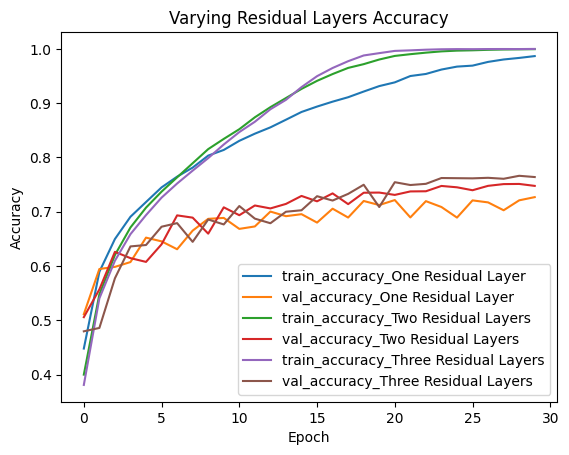

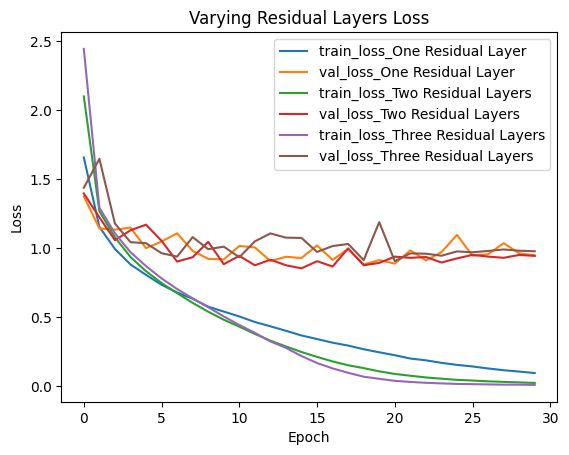

In [ ]:
# Plot accuracy and loss
# accuracy_title = title + ' Accuracy'
# loss_title = title + ' Loss'
# plot_accuracy(resnet_history, accuracy_title)
# plot_loss(resnet_history, loss_title)

# Plot all models' accuracies and losses on the same graph:
plot_multiple_accuracies(histories, title)
plot_multiple_losses(histories, title)

In [ ]:
# Load the model with the maximum validation accuracy from checkpoint on disk
test_model_1 = tf.keras.models.load_model(checkpoint_filepath_1)
test_model_2 = tf.keras.models.load_model(checkpoint_filepath_2)
test_model_3 = tf.keras.models.load_model(checkpoint_filepath_3)
test_model_4 = tf.keras.models.load_model(checkpoint_filepath_4)

In [ ]:
# Evaluate test set using best version of each model and save outputs to a file
print(title + ':')
accuracy_list = []
for i in range(len(models)):
    accuracy_list.append(evaluate_model(models[i], X_test, Y_test))

with open("Test_Accuracy.txt", 'a') as file:
    file_title = title + ':\n'
    file.write(file_title)
    for i in range(len(accuracy_list)):
        acc_string = str(keys[i]) + '\t' + str(accuracy_list[i]) + '\n'
        file.write(acc_string)
    file.write('\n')

Varying Residual Layers:
Test Accuracy: 72.08%
Test Accuracy: 74.18%
Test Accuracy: 75.70%


In [ ]:
from playsound import playsound
playsound("GOT TO GO.mp3")
playsound("GOT TO GO.mp3")
playsound("GOT TO GO.mp3")

In [ ]:
# Extra setup for loading specific models and evaluating
# test_model = tf.keras.models.load_model("ckpt\Baseline ResNet Model\Baseline")
# evaluate_model(test_model, X_test, Y_test)